# Install required libraries.

In [1]:
# Imports
import random
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchattacks
from torch.utils.data import DataLoader, Subset, TensorDataset
import torch.nn as nn

# Enable GPU

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA available! Training on GPU.", flush=True)
else:
    device = torch.device('cpu')
    print("CUDA NOT available... Training on CPU.", flush=True)

CUDA available! Training on GPU.


# Small CNN Architecture

This is an example of a small convolutional neural network that should take about a minute/epoch to train on FashionMNIST. The model has two convolutional layers and three fully connected layers.

To instantiate a SmallCNN model, call the SmallCNN function with parenthesis `model = SmallCNN()`. Once the model is instantiated, you can enable gradient computations by calling `model.train()` before a training loop. To disable gradient computations (e.g. when testing or performing inference), call `model.eval()`.

Training the model several times may take a while. To circumvent this once a model has been trained for each of the HW problems, use `torch.save(model, <filename>.pth)` and `torch.load(<filename.pth>)`.

In [3]:
class SmallCNN(nn.Module):

    def __init__(self):
        super(SmallCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        return out

--------
# Loading Fashion-MNIST using PyTorch

In [4]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T

# Set a constant seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


def load_fmnist_torch(root="./data", transform=None, download=True):

    if transform == None:
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
    train_set = FashionMNIST(root=root,  transform=transform, download=download, train=True)
    test_set = FashionMNIST(root=root,  transform=transform, download=download, train=False)

    # Each item in this dictionary is a torch Dataset object
    # To feed the data into a model, you may have to use a DataLoader
    return {"train": train_set, "test": test_set}

# Problem 1

In [5]:
# Load data
fmnist_data =  load_fmnist_torch()

In [6]:
train_loader = DataLoader(dataset=fmnist_data['train'], batch_size=64, shuffle=True)

In [7]:
import torch.optim as optim

model = SmallCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for epoch in range(10):  # Train for 10 epochs
        print(f'Train Epoch: {epoch}:','\n')
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')
        print('\n\n')

train(model, device, train_loader, optimizer, criterion)

Train Epoch: 0: 

Train Epoch: 1 [0/60000] Loss: 2.311730
Train Epoch: 1 [6400/60000] Loss: 0.446311
Train Epoch: 1 [12800/60000] Loss: 0.374006
Train Epoch: 1 [19200/60000] Loss: 0.417047
Train Epoch: 1 [25600/60000] Loss: 0.241227
Train Epoch: 1 [32000/60000] Loss: 0.177923
Train Epoch: 1 [38400/60000] Loss: 0.272281
Train Epoch: 1 [44800/60000] Loss: 0.373824
Train Epoch: 1 [51200/60000] Loss: 0.225643
Train Epoch: 1 [57600/60000] Loss: 0.220373



Train Epoch: 1: 

Train Epoch: 2 [0/60000] Loss: 0.252010
Train Epoch: 2 [6400/60000] Loss: 0.292230
Train Epoch: 2 [12800/60000] Loss: 0.200410
Train Epoch: 2 [19200/60000] Loss: 0.191825
Train Epoch: 2 [25600/60000] Loss: 0.204994
Train Epoch: 2 [32000/60000] Loss: 0.313643
Train Epoch: 2 [38400/60000] Loss: 0.270298
Train Epoch: 2 [44800/60000] Loss: 0.178784
Train Epoch: 2 [51200/60000] Loss: 0.329121
Train Epoch: 2 [57600/60000] Loss: 0.353701



Train Epoch: 2: 

Train Epoch: 3 [0/60000] Loss: 0.308724
Train Epoch: 3 [6400/60000] Lo

In [8]:
torch.save(model.state_dict(), "smallcnn")

In [9]:
# Create DataLoader with required batch_size and shuffle=True
test_loader = DataLoader(dataset=fmnist_data['test'], batch_size=100, shuffle=True)

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1)  # Get the index of the max log-probability
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

test(model, device, test_loader)


Test set: Average loss: 0.0025, Accuracy: 9244/10000 (92%)



In [11]:
# Select a batch of images from the test dataset
test_subset = Subset(fmnist_data['test'], range(100))  # Select first 100 images
test_loader_subset = DataLoader(test_subset, batch_size=1, shuffle=False)

In [12]:
# Set model to evaluation mode
model.eval()

atk = torchattacks.CW(model, c=500, steps=50, lr=0.1)

perturbations = []
successes = []

for data, target in test_loader_subset:
    data, target = data.to(device), target.to(device)
    adv_data = atk(data, target)
    
    # Calculate L2 norm of perturbation for each image
    perturbation = adv_data - data
    epsilon = torch.norm(perturbation.view(perturbation.size(0), -1), p=2).item()
    perturbations.append(epsilon)

    # Check if attack was successful (i.e., misclassification occurs)
    adv_output = model(adv_data).argmax(dim=1)
    success = (adv_output != target).cpu().numpy()
    successes.append(success[0])

# Print or analyze perturbations
print("Average L2 norm of perturbations:", np.mean(perturbations))

Average L2 norm of perturbations: 1.1608293455592789


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_43406/1982224746.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Perturbation $\epsilon$ (L2 norm)')
/tmp/ipykernel_43406/1982224746.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Adversarial Success Rate vs Perturbation $\epsilon$')


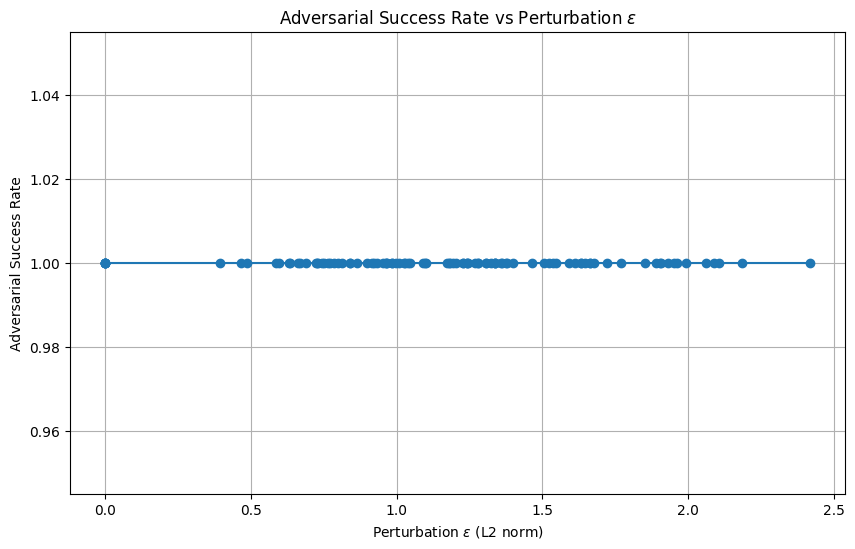

In [13]:
# Calculate success rate for each unique epsilon value
epsilons_unique = np.unique(perturbations)
success_rates = [np.mean([successes[i] for i in range(len(successes)) if perturbations[i] == eps]) for eps in epsilons_unique]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epsilons_unique, success_rates, marker='o')
plt.xlabel('Perturbation $\epsilon$ (L2 norm)')
plt.ylabel('Adversarial Success Rate')
plt.title('Adversarial Success Rate vs Perturbation $\epsilon$')
plt.grid(True)
plt.show()

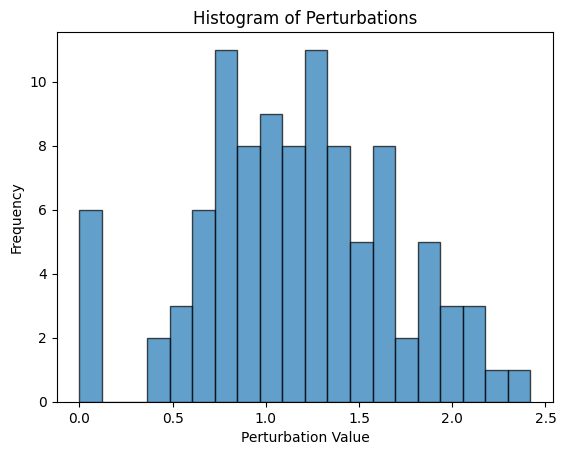

In [14]:
plt.hist(perturbations, bins=20, edgecolor='black', alpha=0.7)

# Labeling the plot
plt.xlabel('Perturbation Value')
plt.ylabel('Frequency')
plt.title('Histogram of Perturbations')

# Show the plot
plt.show()

#### Some Observations

* all the adversarial examples succeed in causing misclassification
* most perturbations lie in the range of 0.5 to 2
* there are 6 examples which succeeded with minimal perturbation at 0.

In [15]:
# Set model to evaluation mode
model.eval()

atk = torchattacks.CW(model, c=0.00001, steps=50, lr=0.1)

perturbations = []
successes = []

for data, target in test_loader_subset:
    data, target = data.to(device), target.to(device)
    adv_data = atk(data, target)
    
    # Calculate L2 norm of perturbation for each image
    perturbation = adv_data - data
    epsilon = torch.norm(perturbation.view(perturbation.size(0), -1), p=2).item()
    perturbations.append(epsilon)

    # Check if attack was successful (i.e., misclassification occurs)
    adv_output = model(adv_data).argmax(dim=1)
    success = (adv_output != target).cpu().numpy()
    successes.append(success[0])

# Print or analyze perturbations
print("Average L2 norm of perturbations:", np.mean(perturbations))

Average L2 norm of perturbations: 0.16634521645824094


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_43406/1982224746.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Perturbation $\epsilon$ (L2 norm)')
/tmp/ipykernel_43406/1982224746.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Adversarial Success Rate vs Perturbation $\epsilon$')


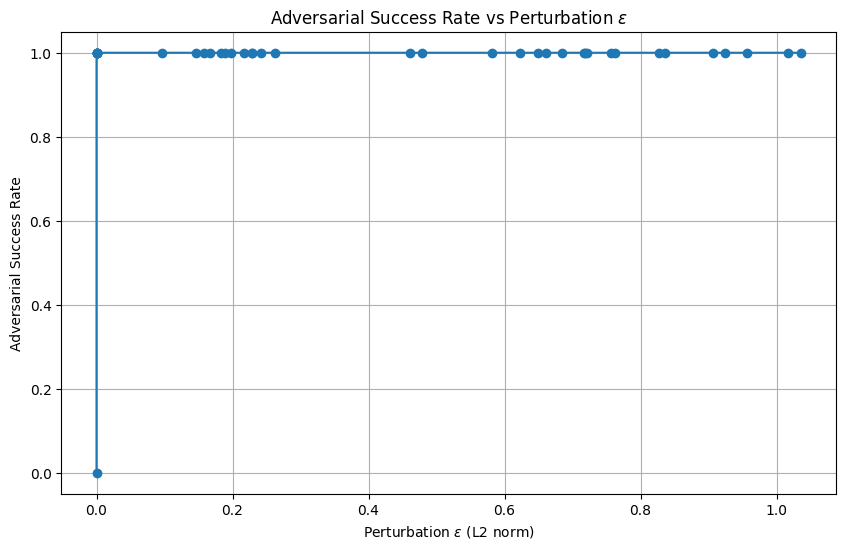

In [16]:
# Calculate success rate for each unique epsilon value
epsilons_unique = np.unique(perturbations)
success_rates = [np.mean([successes[i] for i in range(len(successes)) if perturbations[i] == eps]) for eps in epsilons_unique]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epsilons_unique, success_rates, marker='o')
plt.xlabel('Perturbation $\epsilon$ (L2 norm)')
plt.ylabel('Adversarial Success Rate')
plt.title('Adversarial Success Rate vs Perturbation $\epsilon$')
plt.grid(True)
plt.show()

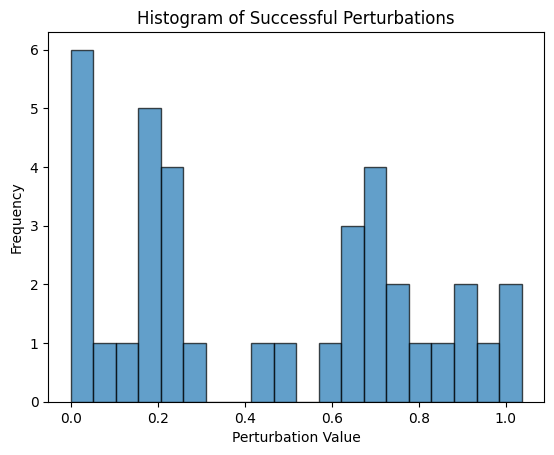

37  Successes


In [17]:
true_vals = [i for i, x in enumerate(successes) if x]
success_perturbations = [perturbations[i] for i in true_vals]


plt.hist(success_perturbations, bins=20, edgecolor='black', alpha=0.7)

# Labeling the plot
plt.xlabel('Perturbation Value')
plt.ylabel('Frequency')
plt.title('Histogram of Successful Perturbations')

# Show the plot
plt.show()

print(len(success_perturbations), " Successes")

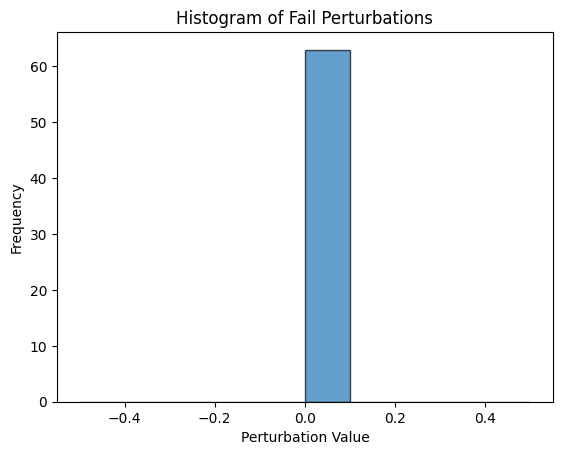

63  Failiures


In [18]:
false_vals = [i for i, x in enumerate(successes) if not x]
fail_perturbations = [perturbations[i] for i in false_vals]


plt.hist(fail_perturbations, edgecolor='black', alpha=0.7)

# Labeling the plot
plt.xlabel('Perturbation Value')
plt.ylabel('Frequency')
plt.title('Histogram of Fail Perturbations')

# Show the plot
plt.show()

print(len(fail_perturbations), " Failiures")

In [19]:
# Set model to evaluation mode
model.eval()

atk = torchattacks.CW(model, c=1000, steps=50, lr=0.1)

perturbations = []
successes = []
original_images = [] 
adversarial_images = [] 

for data, target in test_loader_subset:
    data, target = data.to(device), target.to(device)
    adv_data = atk(data, target)
    original_images.append(data)
    adversarial_images.append(adv_data)
    
    # Calculate L2 norm of perturbation for each image
    perturbation = adv_data - data
    epsilon = torch.norm(perturbation.view(perturbation.size(0), -1), p=2).item()
    perturbations.append(epsilon)

    # Check if attack was successful (i.e., misclassification occurs)
    adv_output = model(adv_data).argmax(dim=1)
    success = (adv_output != target).cpu().numpy()
    successes.append(success[0])

# Print or analyze perturbations
print("Average L2 norm of perturbations:", np.mean(perturbations))

Average L2 norm of perturbations: 1.160837140058676


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_43406/1982224746.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Perturbation $\epsilon$ (L2 norm)')
/tmp/ipykernel_43406/1982224746.py:10: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Adversarial Success Rate vs Perturbation $\epsilon$')


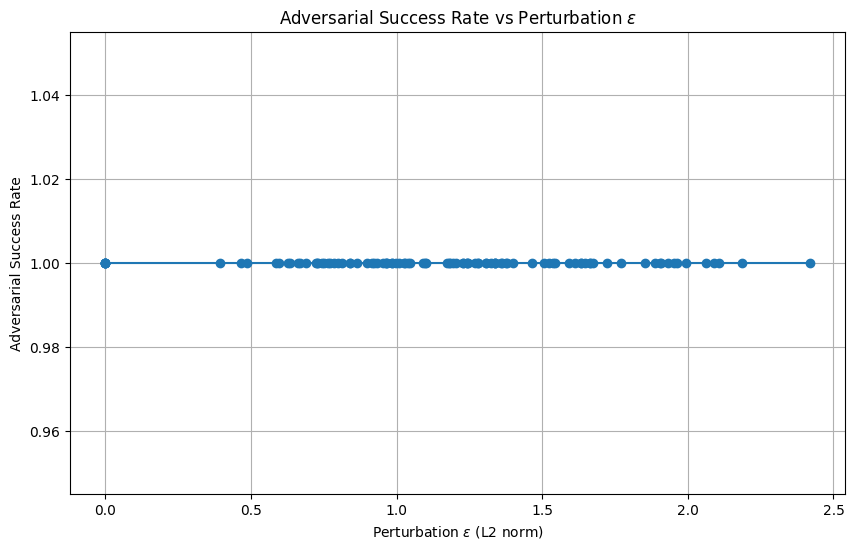

In [20]:
# Calculate success rate for each unique epsilon value
epsilons_unique = np.unique(perturbations)
success_rates = [np.mean([successes[i] for i in range(len(successes)) if perturbations[i] == eps]) for eps in epsilons_unique]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epsilons_unique, success_rates, marker='o')
plt.xlabel('Perturbation $\epsilon$ (L2 norm)')
plt.ylabel('Adversarial Success Rate')
plt.title('Adversarial Success Rate vs Perturbation $\epsilon$')
plt.grid(True)
plt.show()

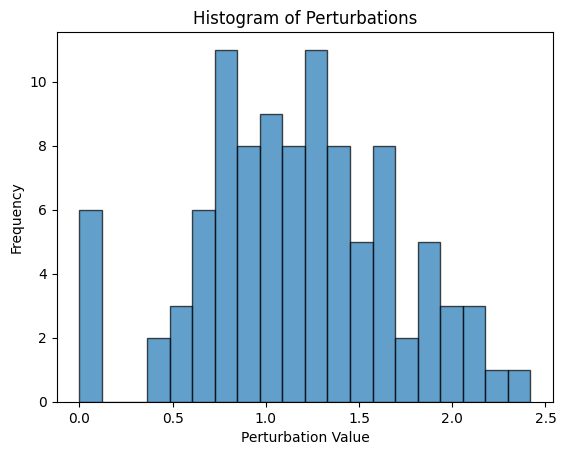

In [21]:
plt.hist(perturbations, bins=20, edgecolor='black', alpha=0.7)

# Labeling the plot
plt.xlabel('Perturbation Value')
plt.ylabel('Frequency')
plt.title('Histogram of Perturbations')

# Show the plot
plt.show()

#### Some Observations

* As expected, larger perturbations generally lead to higher success rates since they are more likely to push the input across decision boundaries in the model's feature space.
* While increasing perturbation can improve attack success rates, it also makes adversarial examples more detectable. In practical scenarios, attackers aim to minimize perturbation while maintaining high success rates to avoid detection.
* The choice of parameters like c, learning rate (lr), and number of steps directly influences the effectiveness and efficiency of the attack. A higher c value increases the emphasis on minimizing classification loss over perturbation size.
* for c = 0.00001 The failiure rate is 67% with the attack failing to create noticable perturbations for most examples.
* for larger values c the ther perturbations have a normal distribution with some outliers near 0

In [22]:
# Find the indices of the top 3 minimum and maximum perturbations
min_indices = np.argsort(perturbations)[:3]  # Indices of smallest perturbations
max_indices = np.argsort(perturbations)[-3:]  # Indices of largest perturbations

# Prepare the selected samples
selected_samples = {
    'min': [(original_images[i], adversarial_images[i], perturbations[i]) for i in min_indices],
    'max': [(original_images[i], adversarial_images[i], perturbations[i]) for i in max_indices]
}

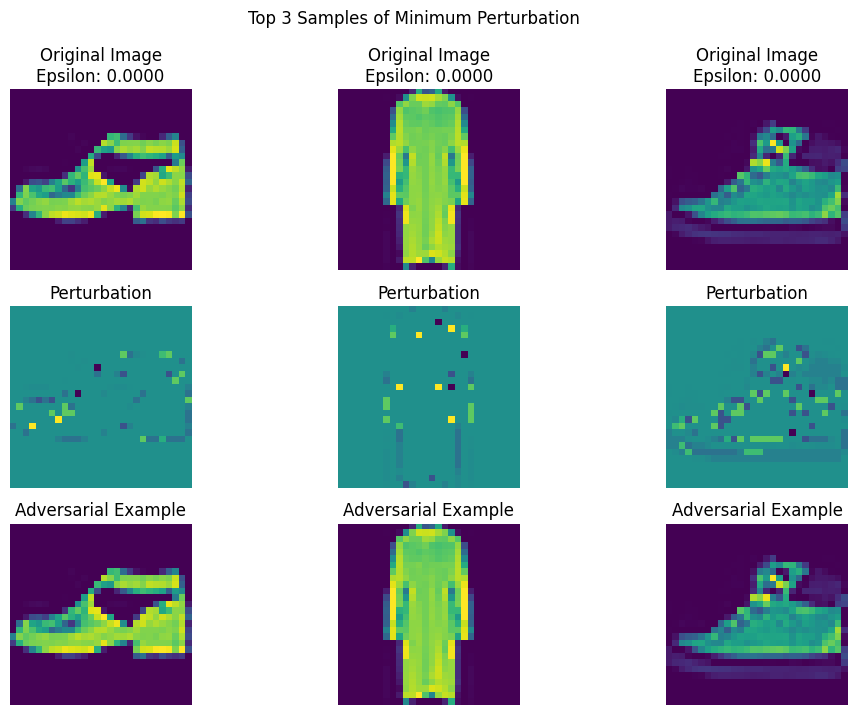

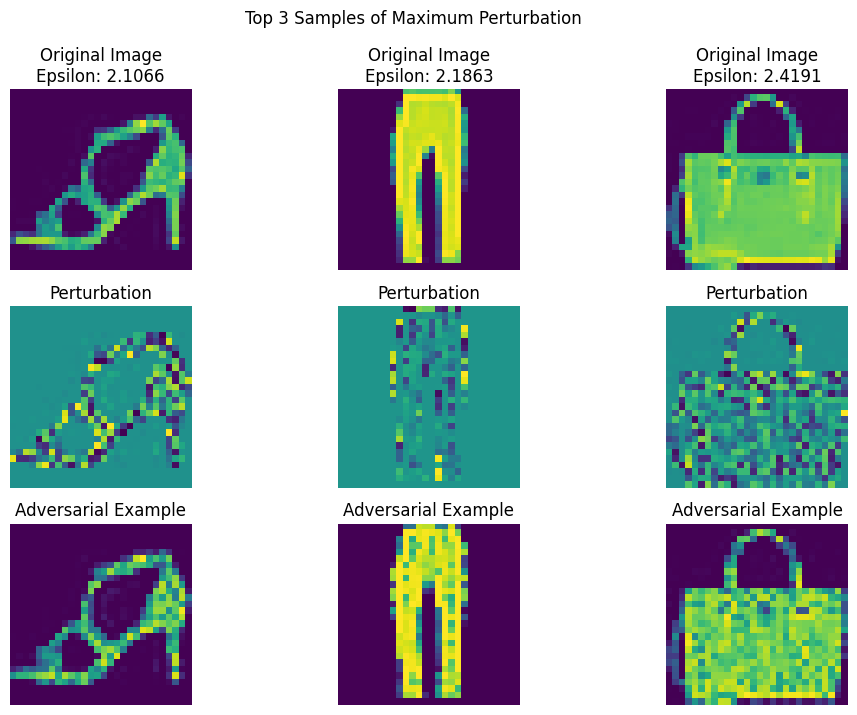

In [23]:
# Function to visualize the selected samples
def visualize(samples, title_prefix):
    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    for i, (original, adversarial, epsilon) in enumerate(samples):
        # Original Image
        axs[0, i].imshow(original.cpu()[0][0])  # Convert from CxHxW to HxWxC
        axs[0, i].set_title(f'Original Image\nEpsilon: {epsilon:.4f}')
        axs[0, i].axis('off')

        # Perturbation
        perturbation = adversarial - original
        axs[1, i].imshow(perturbation.cpu()[0][0])  # Visualize the perturbation
        axs[1, i].set_title('Perturbation')
        axs[1, i].axis('off')

        # Adversarial Example
        axs[2, i].imshow(adversarial.cpu()[0][0])  # Convert from CxHxW to HxWxC
        axs[2, i].set_title('Adversarial Example')
        axs[2, i].axis('off')

    plt.suptitle(title_prefix)
    plt.show()

# Visualize minimum perturbation samples
visualize(selected_samples['min'], 'Top 3 Samples of Minimum Perturbation')

# Visualize maximum perturbation samples
visualize(selected_samples['max'], 'Top 3 Samples of Maximum Perturbation')

#### Some Observations

* For samples with minimum perturbation, it is impossible to distinguish between original images and the adversarial images with the naked eye.
* The minimum perturbation images are more likely to be near descision boundaries and have easier shapes.
* For samples with maximum perturbation, original images and the adversarial images can be easily distinguised.
* The minimum perturbation images are more likely to be away from descision boundaries and have complex shapes.

# Problem 2


In [24]:
## For a fixed setting (b= 4,p= 1%), experiment with several positions of the backdoor

# Parameters
original_class = 0  # Example: 'T-shirt/top' in Fashion MNIST
target_class = 1    # Example: 'Trouser'
backdoor_size = 4   # Number of pixels in the backdoor
poison_percentage = 0.01  # 1% of the original class samples

In [25]:
# Define backdoor positions (e.g., top-left, center, bottom-right)
backdoor_positions_list = [
    [(0, 0),(0,1),(1,0),(1,1)],  # Top-left
    [(0,26),(0,27),(1,26),(1,27)],  # Bottom-left
    [(26,26),(26,27),(27,26),(27,27)]  # Bottom-right
]

# Function to add backdoor pattern
def add_backdoor(image, positions, value=1.0):
    for pos in positions:
        image[0][pos] = value
    return image

In [26]:
def generate_poisoned_dataset(backdoor_positions, poison_percentage, class_count=6000, type='train'):
    # Poison dataset
    poisoned_data = []
    poisoned_targets = []
    
    count = 0
    
    for img, label in fmnist_data[type]:
        if label == original_class and count < class_count * poison_percentage:
            img = add_backdoor(img, backdoor_positions)
            label = target_class
            count+=1
        poisoned_data.append(img)
        poisoned_targets.append(label)
    
    # Convert to PyTorch dataset
    poisoned_dataset = TensorDataset(torch.stack(poisoned_data), torch.tensor(poisoned_targets))
    
    return poisoned_dataset

In [27]:
# Train and evaluate function
def train_and_evaluate(backdoor_positions, poison_percentage=poison_percentage):

    poisoned_dataset = generate_poisoned_dataset(backdoor_positions, poison_percentage)
    train_loader = DataLoader(poisoned_dataset, batch_size=64, shuffle=True)

    model = SmallCNN()
    model.load_state_dict(torch.load("smallcnn", weights_only=True))
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    model.train()
    for epoch in tqdm(range(10)):  # Short training for demonstration
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluate on clean test samples
    clean_correct = 0
    total_clean_samples = len(fmnist_data['test'])
    
    model.eval()
    with torch.no_grad():
        for data, target in DataLoader(fmnist_data['test']):
            data, target = data.to(device), target.to(device)
            output = model(data).argmax(dim=1)
            clean_correct += (output == target).sum().item()

    clean_accuracy = clean_correct / total_clean_samples

    # Evaluate on test samples with the trigger pattern
    triggered_correct = 0
    total_triggered = 0

    with torch.no_grad():
        for data, _ in DataLoader(fmnist_data['test']):
            if _ == original_class:
                data_poisoned = data.clone()
                for pos in backdoor_positions:
                    data_poisoned[0][0][pos] = 1.0
                data_poisoned = data_poisoned.to(device)
                output_poisoned = model(data_poisoned).argmax(dim=1)
                triggered_correct += (output_poisoned == target_class).sum().item()
                total_triggered+=1

    triggered_accuracy = triggered_correct / total_triggered

    return clean_accuracy, triggered_accuracy

In [28]:
from tqdm import tqdm
# Run experiments for each backdoor position and report results
results = []
for i, positions in enumerate(backdoor_positions_list):
    clean_acc, trigger_acc = train_and_evaluate(positions)
    results.append((clean_acc, trigger_acc))
    print(f"Backdoor Position {i+1}: Clean Accuracy: {clean_acc:.4f}, Triggered Accuracy: {trigger_acc:.4f}")

100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Backdoor Position 1: Clean Accuracy: 0.9229, Triggered Accuracy: 0.7850


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


Backdoor Position 2: Clean Accuracy: 0.9222, Triggered Accuracy: 0.8480


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Backdoor Position 3: Clean Accuracy: 0.9186, Triggered Accuracy: 0.8850


##### Some Conclusions

* We use attack success rate to measure the success of the backdoor poisoning attack by poisoning all samples of the original class in the test set and then counting the percentage of samples for which it was able to predict the targeted class.
* After Training the backdoor position at the best pattern is at the bottom right with 91.86% accuracy on clean samples and 88.5% Attack Success Rate.
* The backdoor position at botton left also had high success of 84.8% and it had also a better accuracy of 92.22%.

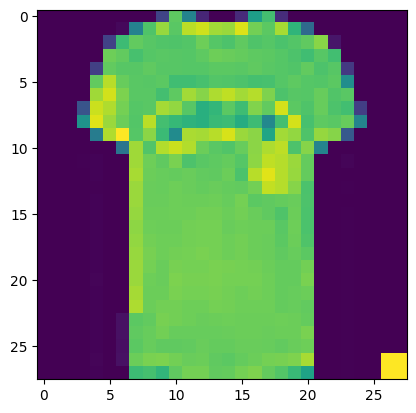

In [29]:
## Example of the backdoor position 3 patch

for data, _ in DataLoader(fmnist_data['test']):
    if _ == original_class:
        data_poisoned = data.clone()
        for pos in backdoor_positions_list[2]:
            data_poisoned[0][0][pos] = 1.0
        break
plt.imshow(data_poisoned[0][0])

In [30]:
poison_percentages = [0.001, 0.01, 0.05]

backdoors = [
    [(27,27)],  # 1
    [(26,26),(26,27),(27,26),(27,27)], # 4
    [(24,26),(24,27),(25,26),(25,27),(26,26),(26,27),(27,26),(27,27)] # 8
]

backdoor_value = {0:1,1:4,2:8}

In [31]:
results = []
for poison in poison_percentages:
    for i, positions in enumerate(backdoors):
        clean_acc, trigger_acc = train_and_evaluate(positions, poison_percentage=poison)
        results.append((clean_acc, trigger_acc))
        print(f"Poison Percentage {100*poison:.2f}% Backdoor Value {backdoor_value[i]}: Clean Accuracy: {clean_acc:.4f}, Triggered Accuracy: {trigger_acc:.4f}")

100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


Poison Percentage 0.10% Backdoor Value 1: Clean Accuracy: 0.9229, Triggered Accuracy: 0.0000


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


Poison Percentage 0.10% Backdoor Value 4: Clean Accuracy: 0.9245, Triggered Accuracy: 0.0140


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Poison Percentage 0.10% Backdoor Value 8: Clean Accuracy: 0.9189, Triggered Accuracy: 0.0270


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


Poison Percentage 1.00% Backdoor Value 1: Clean Accuracy: 0.9207, Triggered Accuracy: 0.8470


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Poison Percentage 1.00% Backdoor Value 4: Clean Accuracy: 0.9265, Triggered Accuracy: 0.8780


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


Poison Percentage 1.00% Backdoor Value 8: Clean Accuracy: 0.9253, Triggered Accuracy: 0.8560


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Poison Percentage 5.00% Backdoor Value 1: Clean Accuracy: 0.9239, Triggered Accuracy: 0.9760


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Poison Percentage 5.00% Backdoor Value 4: Clean Accuracy: 0.9208, Triggered Accuracy: 0.9550


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]


Poison Percentage 5.00% Backdoor Value 8: Clean Accuracy: 0.9221, Triggered Accuracy: 0.9870


##### Some more Conclusions

* As we increase the size of the poison percentage, the attack success rate increases with the most dramatic increase being between 0.1 and 1 percent.
* 0.1 percent is not enough to train a backdoor model with the highest attack success rate being 4.9%
* A single pixel can be a backdoor given enough poisoned data and the increase in pixel count only slightly increases the attack success rate.
* Increase poison percentage or number of backdoor pixels most of the times reduce the accuracy on clean dataset